# Import and Functions

In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc
from sklearn import tree
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [2]:
def compute_metrics(y, y_pred, y_proba):
    fpr, tpr, _ = roc_curve(y, y_proba.T[1])
    res_dict = dict(
        precision=precision_score(y, y_pred),
        recall=recall_score(y, y_pred),
        f1=f1_score(y, y_pred),
        accuracy=accuracy_score(y, y_pred),
        roc_auc=auc(fpr, tpr)
    )
    return res_dict, fpr, tpr


def plot_roc_curve(fpr, tpr, auc, name):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label=f'ROC curve (area = {auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name}\nReceiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

# Load Data

In [3]:
idx = -1
train_path = ["train_df.csv", "final_train_df.csv"][idx]
test_path = ["test_df.csv", "final_test_df.csv"][idx]

train = pd.read_csv(train_path)
train_y = train['SepsisLabel']
train_x = train.drop(['id', 'SepsisLabel'], axis=1)
tree_train_x = train_x.fillna(-1)

test = pd.read_csv(test_path)
test_y = test['SepsisLabel']
test_x = test.drop(['id', 'SepsisLabel'], axis=1)
tree_test_x = test_x.fillna(-1)

# Decision Tree

{'precision': 0.9780534351145038, 'recall': 0.7243816254416962, 'f1': 0.8323183110028421, 'accuracy': 0.97935, 'roc_auc': 0.97809797596945}
{'precision': 0.8658088235294118, 'recall': 0.6356275303643725, 'f1': 0.7330739299610896, 'accuracy': 0.9657, 'roc_auc': 0.8886196586783783}


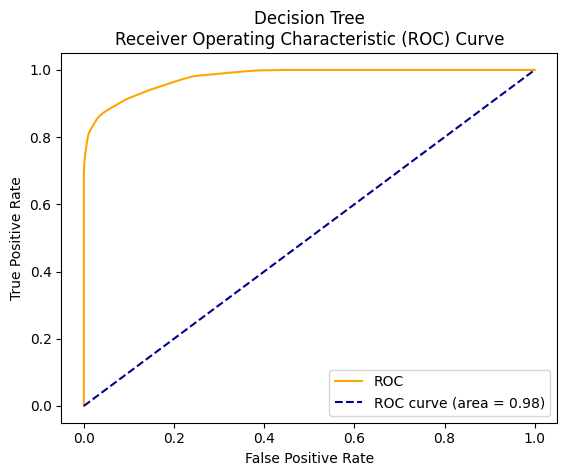

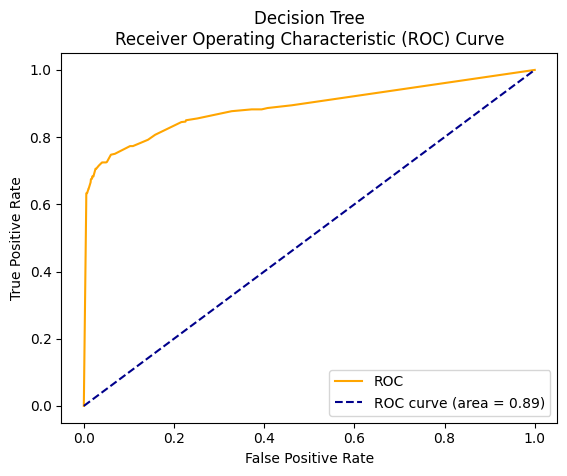

In [4]:
# Best Decision Tree: f1=0.73307
decision_tree_model = tree.DecisionTreeClassifier(
    criterion='entropy', max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=10, random_state=42)
decision_tree_model.fit(tree_train_x, train_y)
y_pred = decision_tree_model.predict(tree_test_x)
y_proba = decision_tree_model.predict_proba(tree_test_x)

y_pred_train = decision_tree_model.predict(tree_train_x)
y_proba_train = decision_tree_model.predict_proba(tree_train_x)
res_dict_train, fpr_tr, tpr_tr = compute_metrics(train_y, y_pred_train, y_proba_train)

res_dict, fpr, tpr = compute_metrics(test_y, y_pred, y_proba)

print(res_dict_train)
print(res_dict)
plot_roc_curve(fpr_tr, tpr_tr, res_dict_train['roc_auc'], 'Decision Tree')
plot_roc_curve(fpr, tpr, res_dict['roc_auc'], 'Decision Tree')

# Random Forest

{'precision': 0.9991423670668954, 'recall': 0.823321554770318, 'f1': 0.9027508717551337, 'accuracy': 0.98745, 'roc_auc': 0.9999106008017788}
{'precision': 0.9148936170212766, 'recall': 0.5222672064777328, 'f1': 0.6649484536082475, 'accuracy': 0.961, 'roc_auc': 0.9406662576835552}


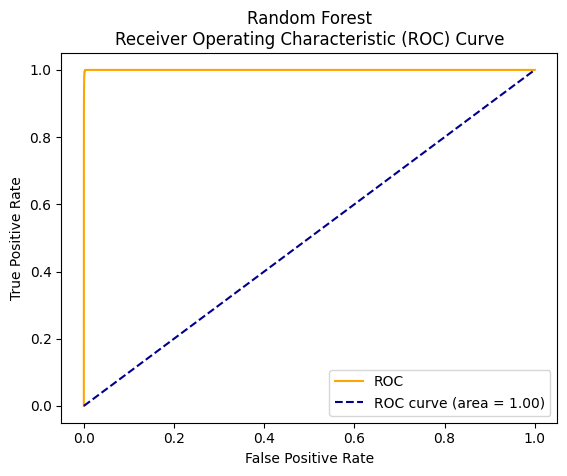

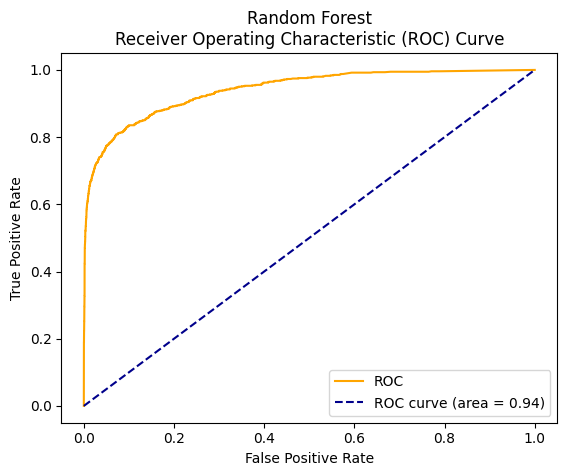

In [5]:
# Best Randpm Forest: f1=0.66494
random_forest_model = RandomForestClassifier(
    criterion='gini', max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=10, n_estimators=100, random_state=42)
random_forest_model.fit(tree_train_x, train_y)
y_pred = random_forest_model.predict(tree_test_x)
y_proba = random_forest_model.predict_proba(tree_test_x)
y_pred_train = random_forest_model.predict(tree_train_x)
y_proba_train = random_forest_model.predict_proba(tree_train_x)
res_dict_train, fpr_tr, tpr_tr = compute_metrics(train_y, y_pred_train, y_proba_train)
res_dict, fpr, tpr = compute_metrics(test_y, y_pred, y_proba)
print(res_dict_train)
print(res_dict)
plot_roc_curve(fpr_tr, tpr_tr, res_dict_train['roc_auc'], 'Random Forest')
plot_roc_curve(fpr, tpr, res_dict['roc_auc'], 'Random Forest')


# XGBoost

{'precision': 0.9929676511954993, 'recall': 0.9978798586572438, 'f1': 0.9954176947479733, 'accuracy': 0.99935, 'roc_auc': 0.9999719367893292}
{'precision': 0.8841761827079935, 'recall': 0.7314439946018894, 'f1': 0.8005908419497785, 'accuracy': 0.973, 'roc_auc': 0.9685596054989134}


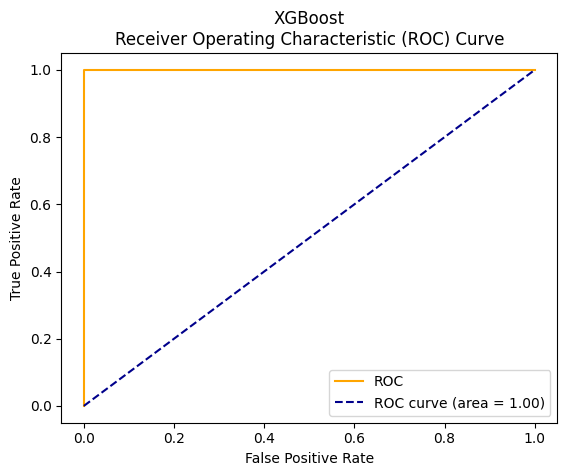

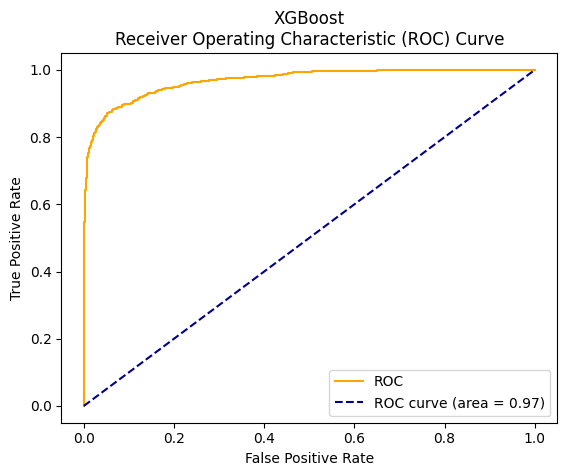

In [6]:
# Best XGBoost:
xgboost_model = XGBClassifier(
    colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth= 5,
    min_child_weight=5, n_estimators=200, scale_pos_weight=5, subsample=0.7)
xgboost_model.fit(train_x, train_y)
y_pred = xgboost_model.predict(test_x)
y_proba = xgboost_model.predict_proba(test_x)
y_pred_train = xgboost_model.predict(train_x)
y_proba_train = xgboost_model.predict_proba(train_x)
res_dict_train, fpr_tr, tpr_tr = compute_metrics(train_y, y_pred_train, y_proba_train)
res_dict, fpr, tpr = compute_metrics(test_y, y_pred, y_proba)
print(res_dict_train)
print(res_dict)
plot_roc_curve(fpr_tr, tpr_tr, res_dict_train['roc_auc'], 'XGBoost')
plot_roc_curve(fpr, tpr, res_dict['roc_auc'], 'XGBoost')

# Save Models

In [7]:
import pickle
with open('best_xgboost.pickle', 'wb') as f: # 0.80
    pickle.dump(xgboost_model, f)

In [8]:
with open('best_decision_tree.pickle', 'wb') as f: # 0.73
    pickle.dump(decision_tree_model, f)

In [9]:
with open('best_random_forest.pickle', 'wb') as f: # 0.66
    pickle.dump(random_forest_model, f)